In [1]:
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('./dracula.mplstyle')
import logging
LOG = logging.getLogger(__name__)
LOG.setLevel(logging.INFO)
LOG.info('Hello from notebook')

from pydataset import data

import frankenfit as ff
reload(ff.core)
reload(ff.transforms)
reload(ff.graph)
reload(ff)

logging.getLogger('frankenfit').setLevel(logging.INFO)

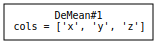

In [2]:
ff.DeMean(["x", "y", "z"]).visualize()

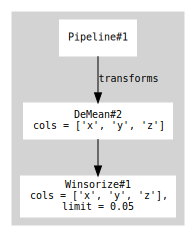

In [3]:
pip = ff.Pipeline(transforms=[
    ff.DeMean(["x", "y", "z"]),
    ff.Winsorize(["x", "y", "z"], limit=0.05),
])
pip.visualize()

In [4]:
pip

Pipeline(tag='Pipeline#1', transforms=[DeMean(tag='DeMean#2', cols=['x', 'y', 'z'], w_col=None), Winsorize(tag='Winsorize#1', cols=['x', 'y', 'z'], limit=0.05)])

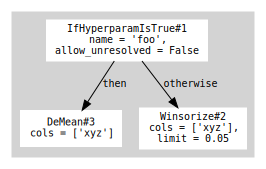

In [5]:
ff.IfHyperparamIsTrue("foo", then=ff.DeMean(["xyz"]), otherwise=ff.Winsorize(["xyz"], 0.05)).visualize()

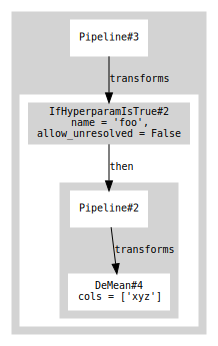

In [6]:
ff.Pipeline(transforms=[
    #ff.IfHyperparamIsTrue("foo", then=ff.Pipeline(transforms=[ff.DeMean(["xyz"])]), otherwise=ff.Winsorize(["xyz"], 0.05))
    ff.IfHyperparamIsTrue("foo", then=ff.Pipeline(transforms=[ff.DeMean(["xyz"])])),
]).visualize()

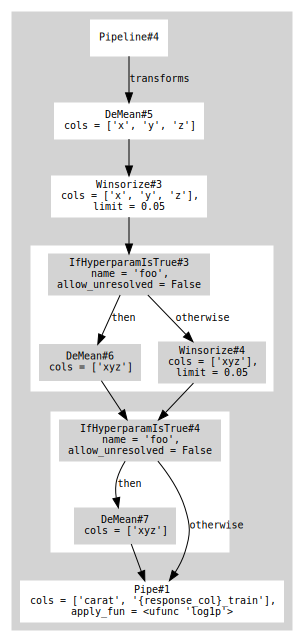

In [7]:
pip = ff.Pipeline(transforms=[
    ff.DeMean(["x", "y", "z"]),
    ff.Winsorize(["x", "y", "z"], limit=0.05),
    ff.IfHyperparamIsTrue("foo", then=ff.DeMean(["xyz"]), otherwise=ff.Winsorize(["xyz"], 0.05)),
    ff.IfHyperparamIsTrue("foo", then=ff.DeMean(["xyz"])),
    ff.Pipe(["carat", "{response_col}_train"], np.log1p),
])
pip.visualize()

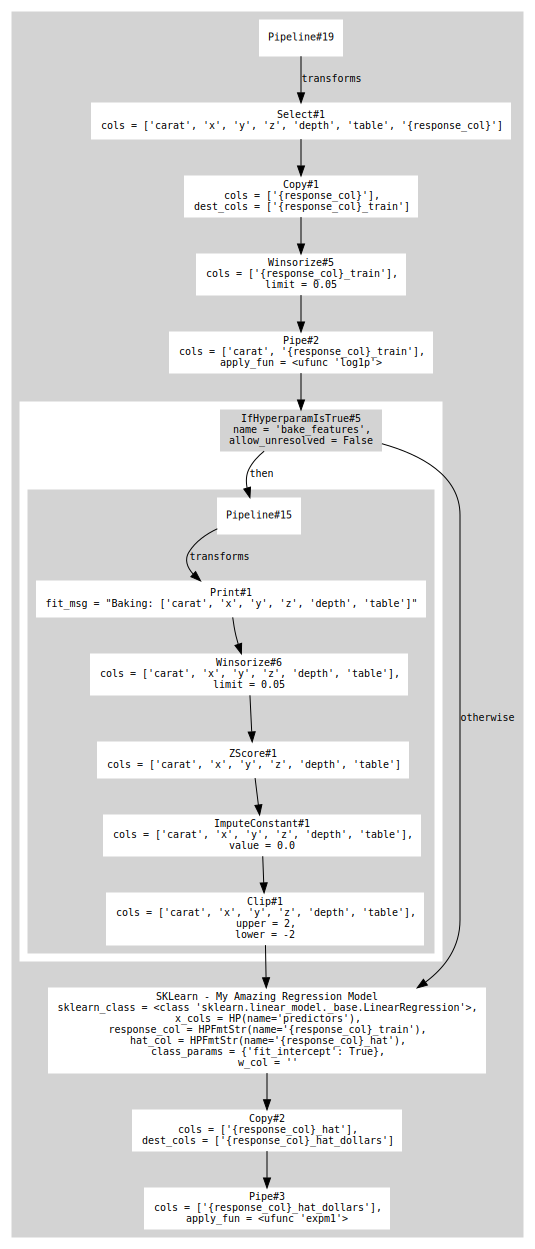

In [8]:
from sklearn.linear_model import LinearRegression

FEATURES = ["carat", "x", "y", "z", "depth", "table"]

def bake_features(cols):
    return (
        ff.Pipeline()
        .print(fit_msg=f"Baking: {cols}")
        .winsorize(cols, limit=0.05)
        .z_score(cols)
        .impute_constant(cols, 0.0)
        .clip(cols, upper=2, lower=-2)
    )

pipeline = (
    ff.Pipeline()
    [FEATURES + ["{response_col}"]]
    .copy("{response_col}", "{response_col}_train")
    .winsorize("{response_col}_train", limit=0.05)
    .pipe(["carat", "{response_col}_train"], np.log1p)
    .if_hyperparam_is_true("bake_features", bake_features(FEATURES))
    .sklearn(
        LinearRegression,
        # x_cols=["carat", "depth", "table"],
        x_cols=ff.HP("predictors"),
        response_col="{response_col}_train",
        hat_col="{response_col}_hat",
        class_params={"fit_intercept": True},
        tag='SKLearn - My Amazing Regression Model',
    )
    # transform {response_col}_hat from log-dollars back to dollars
    .copy("{response_col}_hat", "{response_col}_hat_dollars")
    .pipe("{response_col}_hat_dollars", np.expm1)
)
pipeline.visualize()

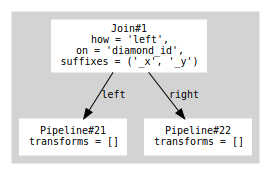

In [10]:
t = ff.Join(ff.Pipeline(), ff.Pipeline(), how="left", on="diamond_id")
t.visualize()

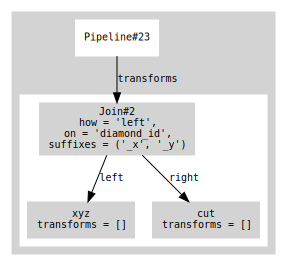

In [11]:
p = ff.Pipeline(
        transforms=[
            ff.Join(ff.Pipeline(tag="xyz"), ff.Pipeline(tag="cut"), how="left", on="diamond_id")
        ]
    )
p.visualize()

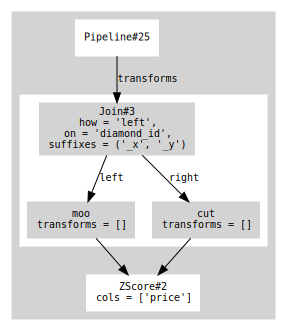

In [12]:
p = ff.Pipeline(tag="moo").join(ff.Pipeline(tag="cut"), how="left", on="diamond_id").z_score(['price'])
p.visualize()

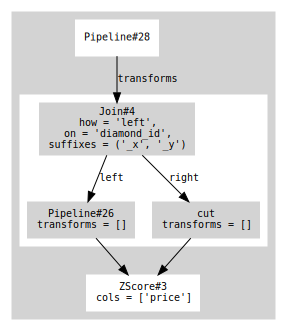

In [13]:
p = ff.Pipeline().join(ff.Pipeline(tag="cut"), how="left", on="diamond_id").z_score(['price'])
p.visualize()

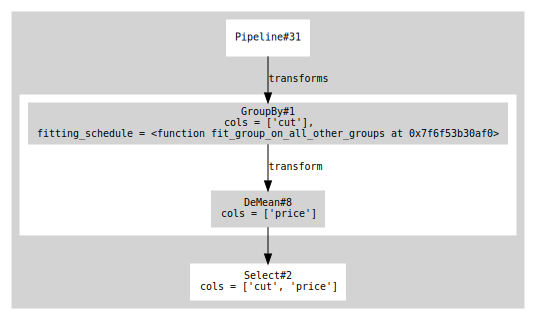

In [14]:
x = (
    ff.Pipeline()
    .group_by("cut", fitting_schedule=ff.fit_group_on_all_other_groups)
        .de_mean(["price"])
    [["cut", "price"]]
)
x.visualize()

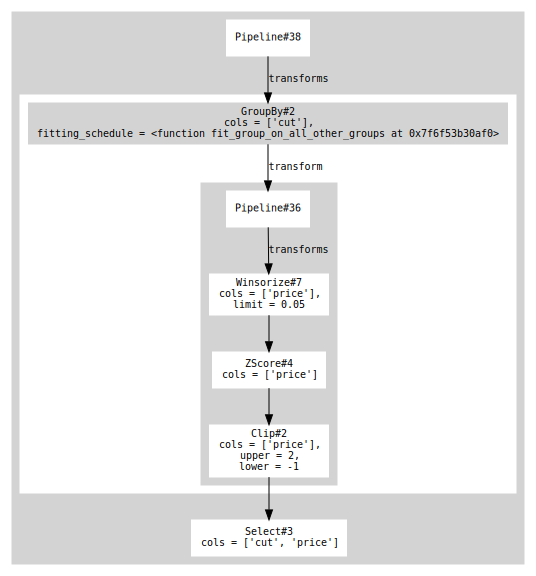

In [15]:
x = (
    ff.Pipeline()
    .group_by("cut", fitting_schedule=ff.fit_group_on_all_other_groups)
        .then(
            ff.Pipeline()
                .winsorize(["price"], limit=0.05)
                .z_score(["price"])
                .clip(["price"], upper=2, lower=-1)
        )
    [["cut", "price"]]
)
x.visualize()

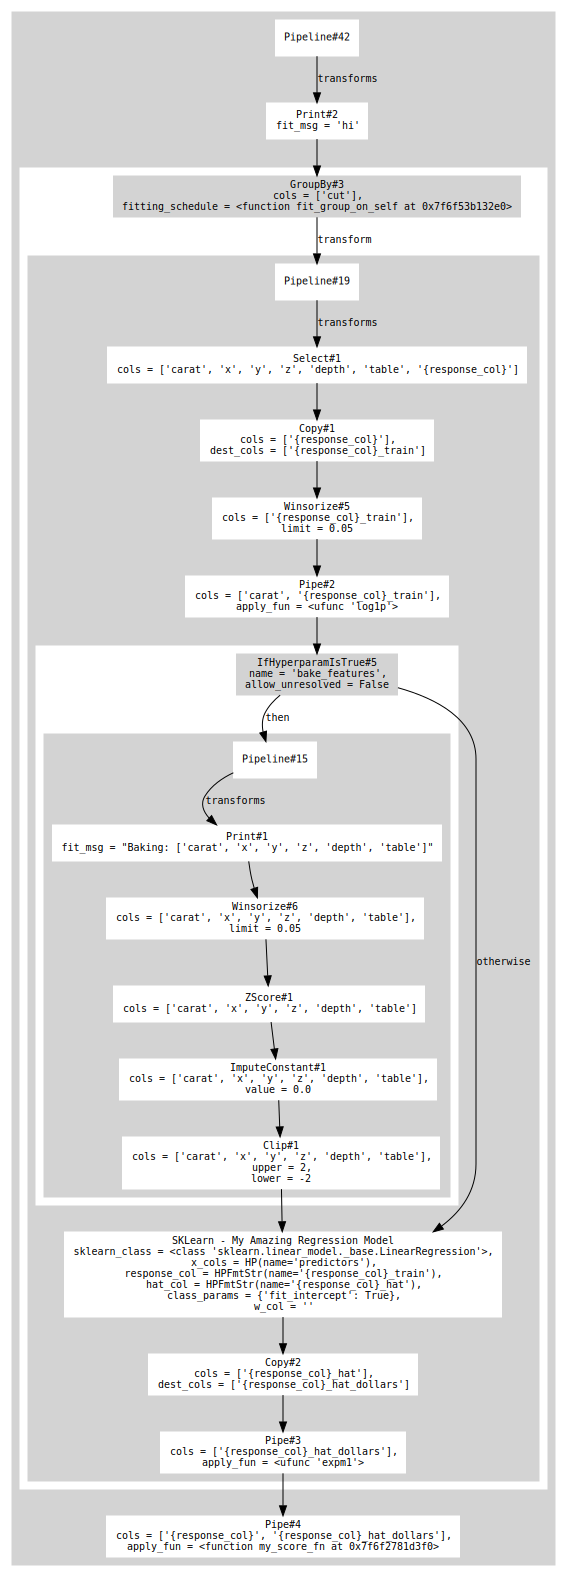

In [16]:
def my_score_fn(df):
    pass

pipeline_grouped = (
    ff.Pipeline()
    .print("hi")
    .group_by("cut")
        #.de_mean("price")
        #.then(ff.DeMean(["price"]))
        .then(pipeline)
    .pipe(["{response_col}", "{response_col}_hat_dollars"], my_score_fn)
)
pipeline_grouped.visualize()

In [17]:
pipeline_grouped

Pipeline(tag='Pipeline#42', transforms=[Print(tag='Print#2', fit_msg='hi', apply_msg=None, dest=None), GroupBy(tag='GroupBy#3', cols=['cut'], transform=Pipeline(tag='Pipeline#19', transforms=[Select(tag='Select#1', cols=['carat', 'x', 'y', 'z', 'depth', 'table', '{response_col}']), Copy(cols=['{response_col}'], tag='Copy#1', dest_cols=['{response_col}_train']), Winsorize(tag='Winsorize#5', cols=['{response_col}_train'], limit=0.05), Pipe(cols=['carat', '{response_col}_train'], tag='Pipe#2', apply_fun=<ufunc 'log1p'>), IfHyperparamIsTrue(tag='IfHyperparamIsTrue#5', name='bake_features', then=Pipeline(tag='Pipeline#15', transforms=[Print(tag='Print#1', fit_msg="Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']", apply_msg=None, dest=None), Winsorize(tag='Winsorize#6', cols=['carat', 'x', 'y', 'z', 'depth', 'table'], limit=0.05), ZScore(tag='ZScore#1', cols=['carat', 'x', 'y', 'z', 'depth', 'table'], w_col=None), ImputeConstant(cols=['carat', 'x', 'y', 'z', 'depth', 'table'], tag='Impute

In [18]:
df = data('diamonds').reset_index().drop(['index'], axis=1)
fit = pipeline.fit(df, bindings={'response_col': 'price', 'bake_features': True, 'predictors': FEATURES})

Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']


In [19]:
pipeline

Pipeline(tag='Pipeline#19', transforms=[Select(tag='Select#1', cols=['carat', 'x', 'y', 'z', 'depth', 'table', '{response_col}']), Copy(cols=['{response_col}'], tag='Copy#1', dest_cols=['{response_col}_train']), Winsorize(tag='Winsorize#5', cols=['{response_col}_train'], limit=0.05), Pipe(cols=['carat', '{response_col}_train'], tag='Pipe#2', apply_fun=<ufunc 'log1p'>), IfHyperparamIsTrue(tag='IfHyperparamIsTrue#5', name='bake_features', then=Pipeline(tag='Pipeline#15', transforms=[Print(tag='Print#1', fit_msg="Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']", apply_msg=None, dest=None), Winsorize(tag='Winsorize#6', cols=['carat', 'x', 'y', 'z', 'depth', 'table'], limit=0.05), ZScore(tag='ZScore#1', cols=['carat', 'x', 'y', 'z', 'depth', 'table'], w_col=None), ImputeConstant(cols=['carat', 'x', 'y', 'z', 'depth', 'table'], tag='ImputeConstant#1', value=0.0), Clip(cols=['carat', 'x', 'y', 'z', 'depth', 'table'], tag='Clip#1', upper=2, lower=-2)]), otherwise=None, allow_unresolved=Fals

In [20]:
pipeline.find_by_tag(
    'SKLearn - My Amazing Regression Model',
)

SKLearn(tag='SKLearn - My Amazing Regression Model', sklearn_class=<class 'sklearn.linear_model._base.LinearRegression'>, x_cols=HP(name='predictors'), response_col=HPFmtStr(name='{response_col}_train'), hat_col=HPFmtStr(name='{response_col}_hat'), class_params={'fit_intercept': True}, w_col='')

In [21]:
fit

FitPipeline(tag='Pipeline#19', transforms=[Select(tag='Select#1', cols=['carat', 'x', 'y', 'z', 'depth', 'table', '{response_col}']), Copy(cols=['{response_col}'], tag='Copy#1', dest_cols=['{response_col}_train']), Winsorize(tag='Winsorize#5', cols=['{response_col}_train'], limit=0.05), Pipe(cols=['carat', '{response_col}_train'], tag='Pipe#2', apply_fun=<ufunc 'log1p'>), IfHyperparamIsTrue(tag='IfHyperparamIsTrue#5', name='bake_features', then=Pipeline(tag='Pipeline#15', transforms=[Print(tag='Print#1', fit_msg="Baking: ['carat', 'x', 'y', 'z', 'depth', 'table']", apply_msg=None, dest=None), Winsorize(tag='Winsorize#6', cols=['carat', 'x', 'y', 'z', 'depth', 'table'], limit=0.05), ZScore(tag='ZScore#1', cols=['carat', 'x', 'y', 'z', 'depth', 'table'], w_col=None), ImputeConstant(cols=['carat', 'x', 'y', 'z', 'depth', 'table'], tag='ImputeConstant#1', value=0.0), Clip(cols=['carat', 'x', 'y', 'z', 'depth', 'table'], tag='Clip#1', upper=2, lower=-2)]), otherwise=None, allow_unresolved=F

In [22]:
fit.find_by_tag(
    'SKLearn - My Amazing Regression Model',
)

FitSKLearn(tag='SKLearn - My Amazing Regression Model', sklearn_class=<class 'sklearn.linear_model._base.LinearRegression'>, x_cols=['carat', 'x', 'y', 'z', 'depth', 'table'], response_col='price_train', hat_col='price_hat', class_params={'fit_intercept': True}, w_col='', <53940 rows of fitting data>)

In [23]:
fit.find_by_tag(
    'SKLearn - My Amazing Regression Model',
).state().coef_

array([-0.35195799,  0.34907305,  0.68264429,  0.27923585,  0.00870615,
       -0.01587139])